# КЛАССИФИКАЦИЯ БАДМИНТОННЫХ УДАРОВ
### ДИПЛОМНЫЙ ПРОЕКТ МАШИННОГО ОБУЧЕНИЯ

Целью этого проекта является классификация бадминтонных ударов, с использованием данных, собранных с небольшого наручного устройства. Это устройство передает нам данные акселерометра и гироскопа и крепится к запястью игрока. Этот дипломный проект включает в себя весь жизненный цикл модели машинного обучения от постановки задачи до вывода модели в продакшн.

## Определение задачи

Для начала нам необходимо определить и правильно сформулировать задачу, которую мы хотим решить. Поскольку мы могли выбрать любую задачу я решил исследовать классификацию типов удара, который выполняет игрок, на основе данных датчика, которые мы получаем от его умных часов. Данное исследование актуально как расширение задачи распознавания человеческой активности, которая на основе аналогичных данных классифицирует действия человека, такие как бег, ходьба и т. д. В нашем случае я решил выделить в классы следующие удары по бадминтону:
* Backhand Overarm бэкхенд (от англ. backhand) (bo)
* Backhand Underarm разновидность бэкхэнда (bu)
* Forehand Overarm форхенд (от англ. forehand) (fo)
* Forehand Underarm разновидность форхенда (fu)
* Forehand Smash атакующий удар (fs)

## Данные
Насколько мне известно, общедоступных данных по этой задаче не было, поэтому я решил собрать данные самостоятельно.

### Настройка сбора данных
Я получил устройство, которое может передавать нам показания акселерометра и гироскопа в течение определенного периода времени на нисходящей частоте. Устройство питалось от небольшой батарейки и подключалось через Bluetooth ко смартфону. Таким образом я собрал данные об ударах в формате csv.

### Сбор данных
Благодаря пяти добровольцам я смог собрать данные для пяти упомянутых ударов. Мы выполняли одни и те же удары много раз. Хотя это может сильно отличаться от реальной игры, но мы постарались играть так, как играют в настоящую игру (т. е. начинать из центрального положения, двигаться к волану и возвращаться в исходное положение). У устройства были свои ограничения (покрытие, мощность и т. д.), что усложняло задачу. Проделав все это, я получили данные для исследования.

## Визуализация данных

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import itertools
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import find_peaks  #для поиска вершин
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import pickle

Данные сохраняются в папке data. Это 25 разных CSV-файлов на 5 игроков по 5 классов ударов. Например файл p2_bu.csv содержит данные игрока с идентификатором 2 для удара Backhand Underarm.

Столбцы в каждом файле: временная метка, magnitudes, ось X акселерометра x-axis (ax), ось Y y-axis (ay), ось Z z-axis (az), ось X гироскопа x-axis (gx), y-axis (gy), z-axis (gz). Я также добавил значения magnitudes акселерометра и гироскопа.

In [2]:
# Столбцы в файлах данных
cols = ['ax', 'ay', 'az', 'gx', 'gy', 'gz']  # Акселерометр и гироскоп в 3-х осях
addedCols = ['acc_mag', 'gyro_mag']          # Magnitude акселерометра и гироскопа

In [3]:
# Чтение данных
data = {}
persons = ["p1", "p2", "p3", "p4", "p5"]
shots = ["bo", "bu", "fo", "fs", "fu"]
for person in persons:
    for shot in shots:
        data[person + "_" + shot] = pd.read_csv("data/" + str(person) + "_" + str(shot) + ".csv")
        data[person + "_" + shot]['acc_mag'] = np.linalg.norm(data[person + "_" + shot][cols[:3]].values,axis=1)
        data[person + "_" + shot]['gyro_mag'] = np.linalg.norm(data[person + "_" + shot][cols[3:]].values,axis=1)

Построим графики одного из CSV-файлов, p5_bo.

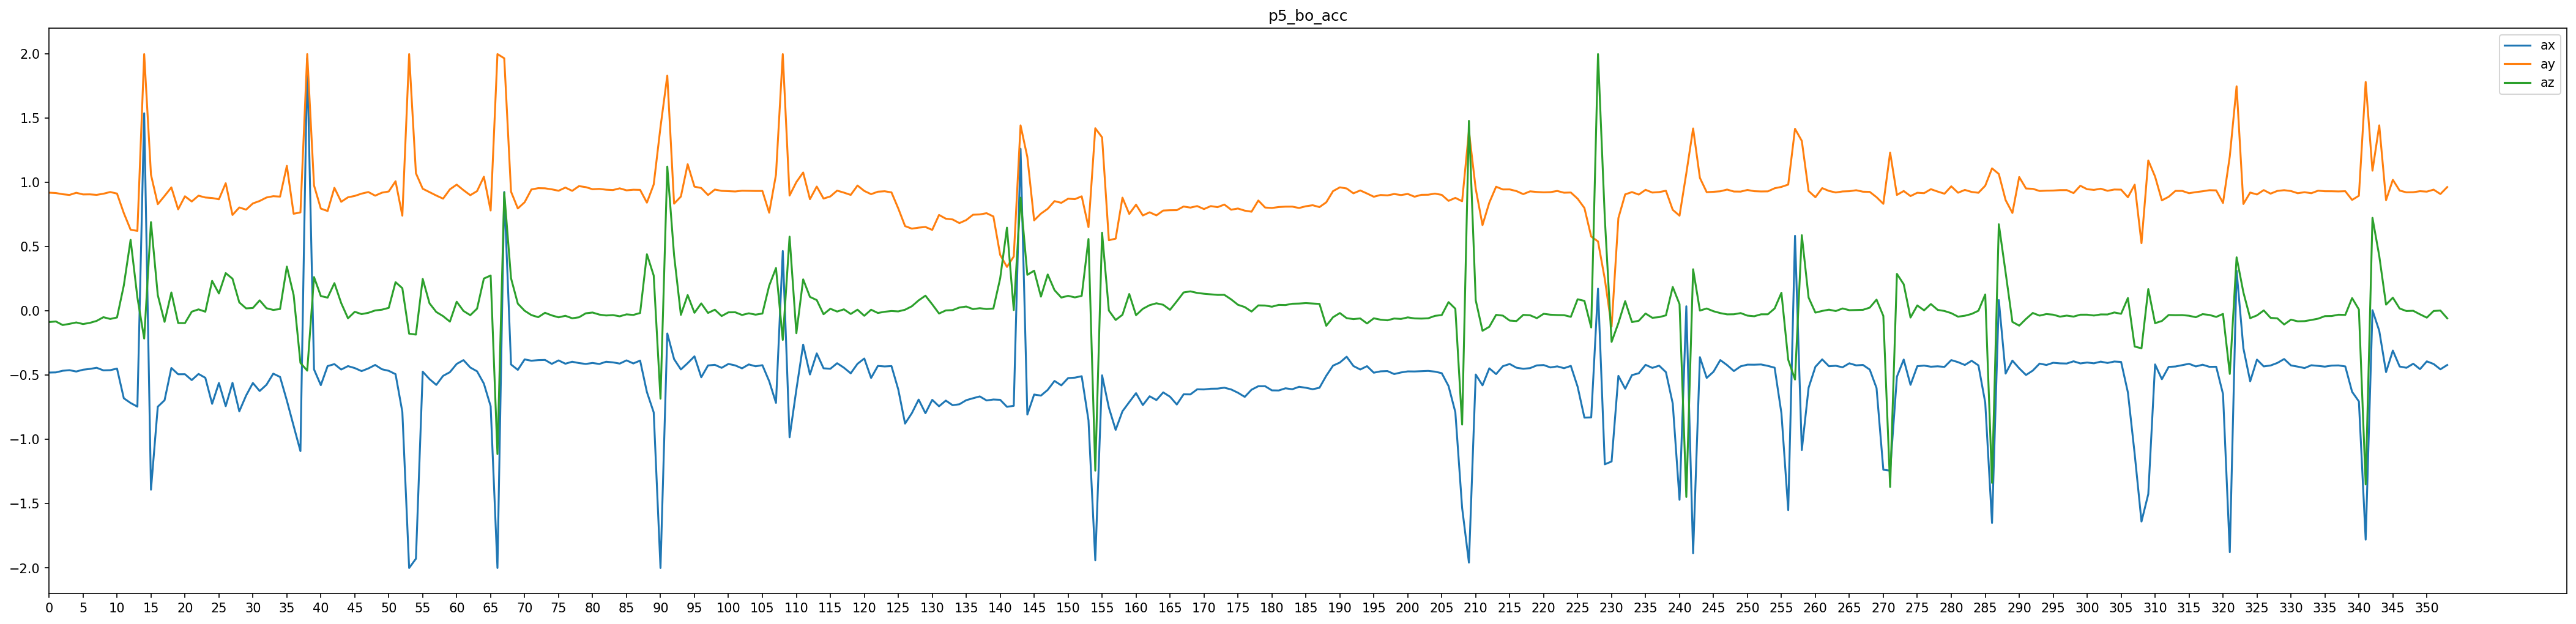

In [4]:
plotName = "p5_bo"

# Установим ширину координатной плоскости в соответствии с количеством показаний
plt.figure(figsize=(len(data[plotName])/10, 8), dpi=150)

# График для каждого столбца акселерометра
for col in cols[0:3]:
    plt.plot(data[plotName][col], label=col)

plt.xlim(xmin=0)
plt.xticks(np.arange(0, len(data[plotName])+1, 5.0))
plt.title(plotName + "_acc")
plt.legend()
plt.show()

## Очистка данных

Пики на графике выше — это удары, а между ними время отдыха. Удары производятся с неравномерными интервалами, иногда период отдыха очень длинный (например, от 160 до 200 на графике выше). Поэтому нам нужно выделить эти периоды отдыха и удалить их как выбросы.


В проведенном EDA исследовании, на основании наших наблюдений, нанеся на график все данные я выбрал размер окна равным 13. Также я выбрал сигнал ay для нахождения пиков и окна с разными пороговыми значениями для каждого класса ударов.

In [5]:
# Размер окна, общий для всех кадров
windowSize = 13

sensorToThreshold = ['ay', 'ay', 'ay', 'ay', 'ay']
threshold = [1.25, 1.25, 1.5, 1.5, 1.5]

In [6]:
# Построение графиков
for p_name in persons:
    for s_name in shots:
        s_index = shots.index(s_name)  # Индекс значения удара
        plotName = p_name + "_" + s_name
        
        # Установим ширину координатной плоскости в соответствии с количеством показаний
        plt.figure(figsize=(len(data[plotName])/10, 5), dpi=100)
        
        # Пики с порогом threashold, значения удара и показания датчика с этим порогом
        peaks, _ = find_peaks(data[plotName][sensorToThreshold[s_index]], height=threshold[s_index])
        #plt.plot(peaks, data[plotName][sensorToThreshold[s_index]][peaks], "x", c='red')
        
        # График для каждого столбца акселерометра
        for col in cols[0:3]:
            plt.plot(data[plotName][col], label=col)

        # Рисование окон вокруг каждой вершины
        for peak in peaks:
            plt.axvspan(int(peak - windowSize/2), int(peak + windowSize/2), alpha =.1, facecolor='g',edgecolor='black')
        
        plt.xlim(xmin=0)
        plt.xticks(np.arange(0, len(data[plotName])+1, 5.0))
        plt.title(plotName + "_acc")
        plt.legend()
        plt.savefig("plots/" + plotName + "_acc")
        #plt.show()
        plt.close();
        
        # Установим ширину координатной плоскости в соответствии с количеством показаний
        plt.figure(figsize=(len(data[plotName])/10, 5), dpi=100)
        
        # График для каждого столбца гироскопа
        for col in cols[3:]:
            plt.plot(data[plotName][col], label=col)

        # Рисование окон вокруг каждой вершины
        for peak in peaks:
            plt.axvspan(int(peak - windowSize/2), int(peak + windowSize/2), alpha =.1, facecolor='g',edgecolor='black')
        
        plt.xlim(xmin=0)
        plt.xticks(np.arange(0, len(data[plotName])+1, 5.0))
        plt.title(plotName + "_gyro")
        plt.legend()
        plt.savefig("plots/" + plotName + "_gyro")
        #plt.show()
        plt.close();
                  
        # Magnitude - Акселерометр
        plt.figure(figsize=(len(data[plotName])/10, 5), dpi=100)

        plt.plot(data[plotName][addedCols[0]], label="Magnitude Accelerometer")

        # Рисование окон вокруг каждой вершины
        for peak in peaks:
            plt.axvspan(int(peak - windowSize/2), int(peak + windowSize/2), alpha =.1, facecolor='g',edgecolor='black')
        
        plt.xlim(xmin=0)
        plt.xticks(np.arange(0, len(data[plotName])+1, 5.0))
        plt.title(plotName + "_mag_acc")
        plt.legend()
        plt.savefig("plots/" + plotName + "_mag_acc")
        #plt.show()
        plt.close();
        
        # Magnitude - Гироскоп
        plt.figure(figsize=(len(data[plotName])/10, 5), dpi=100)

        plt.plot(data[plotName][addedCols[1]], label="Magnitude Gyroscope")

        # Рисование окон вокруг каждой вершины
        for peak in peaks:
            plt.axvspan(int(peak - windowSize/2), int(peak + windowSize/2), alpha =.1, facecolor='g',edgecolor='black')
        
        plt.xlim(xmin=0)
        plt.xticks(np.arange(0, len(data[plotName])+1, 5.0))
        plt.title(plotName + "_mag_gyro")
        plt.legend()
        plt.savefig("plots/" + plotName + "_mag_gyro")
        #plt.show()
        plt.close();
        

Результаты визуализации: 

Акселерометр:
<img src="plots/p5_bu_acc.png">

Гироскоп:
<img src="plots/p5_bu_gyro.png">

Есть некоторые совпадения либо из-за того, что кадры расположены очень близко друг к другу, либо из-за того, что в некоторых кадрах появляются двойные пики. А некоторые удары пропускаются из-за низкого порогового значения. Но я обнаружил, что именно это обеспечивает разумный баланс между получением хороших кадров и отсутствием шума.

Я сохраню начало и конец для каждого из этих извлеченных кадров вместе с их метками. Позже я дополню этот датафрейм признаками, созданными вручную. Мы также сохраняем идентификатор человека, хотя он не используется в классификации.

In [7]:
# Окончательный DataFrame
X_y = pd.DataFrame(columns=['StartFrame', 'EndFrame', 'PersonID', 'ShotName'])

# Создание окончательного датафрейма и добавление начального и конечного кадра окна.
for p_name in persons:
    for s_name in shots:
        s_index = shots.index(s_name)  # Индекс значения удара
        plotName = p_name + "_" + s_name
        # Находим пики внутри окна
        timeSeries = data[plotName][sensorToThreshold[s_index]]
        peaks, _ = find_peaks(timeSeries, height=threshold[s_index])
        for peak in peaks:
            if(peak < windowSize/2 or peak > len(timeSeries)-windowSize/2):
                #print(peak)
                continue
            d = {'StartFrame': int(peak - windowSize/2),
                 'EndFrame': int(peak + windowSize/2), 
                 'PersonID': p_name, 
                 'ShotName': s_name}
            #print(d)
            X_y = X_y.append(d, ignore_index=True)
            

In [8]:
X_y

,StartFrame,EndFrame,PersonID,ShotName
0,4,17,p1,bo
1,7,20,p1,bo
2,22,35,p1,bo
3,60,73,p1,bo
4,75,88,p1,bo
...,...,...,...,...
703,132,145,p5,fu
704,149,162,p5,fu
705,179,192,p5,fu
706,192,205,p5,fu


Я извлек кадры из имеющихся у меня непрерывных данных. Всего кадров: 708. Теперь можно посмотреть насколько велик дисбаланс в наших данных.

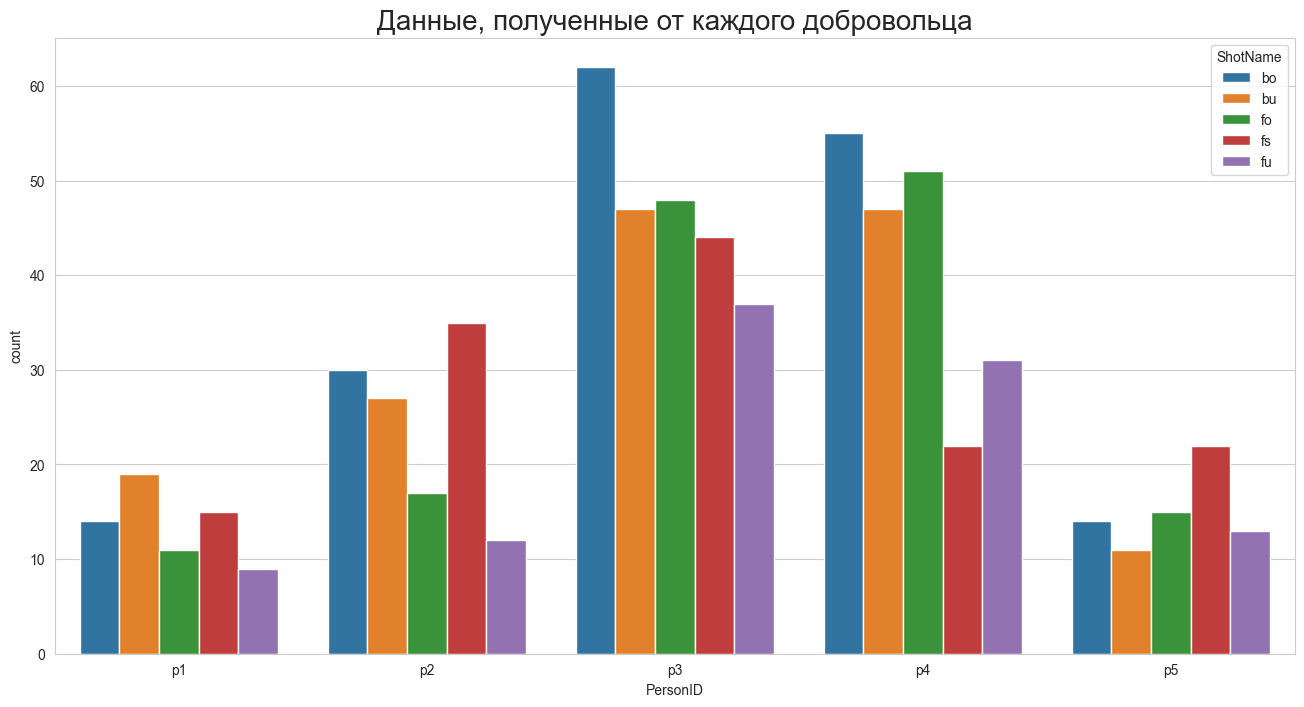

In [9]:
sns.set_style('whitegrid')
plt.figure(figsize=(16,8))
plt.title('Данные, полученные от каждого добровольца', fontsize=20)
sns.countplot(x='PersonID', hue='ShotName', data = X_y)
plt.savefig("plots/data_count")

plt.show()

C:\Users\Станислав\AppData\Local\Temp\ipykernel_5284\2324512171.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  sns.scatterplot([shotFullName[i] for i in X_y.ShotName]).set_xticklabels([shotFullName[i] for i in shots],


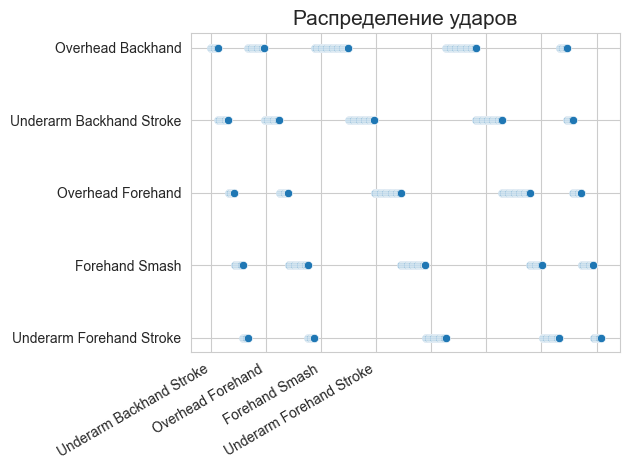

In [10]:
shotFullName = {
    'fo': "Overhead Forehand",
    'bo': "Overhead Backhand",
    'fs': "Forehand Smash",
    'fu': "Underarm Forehand Stroke",
    'bu': "Underarm Backhand Stroke",
}
plt.title('Распределение ударов', fontsize=15)
sns.scatterplot([shotFullName[i] for i in X_y.ShotName]).set_xticklabels([shotFullName[i] for i in shots], 
                                                                       rotation=30, horizontalalignment='right')

plt.tight_layout()
plt.savefig("plots/stroke_count")
plt.show()

Существует большая разница в объеме данных, которые мы собрали от каждого человека. Но большого дисбаланса между классами нет, распределение данных близко к нормальному.

## Добавление признаков для моделей машинного обучения

Мы будем использовать датафрейм данных X_y для хранения всех наших признаков. А затем использовать его для обучения моделей машинного обучения.

Добавляем следующие признаки:
* Диапазон Range
* Минимум Minimum
* Максимум Maximum
* Среднее Average
* Абсолютное среднее значение Absolute Average
* Kurtosis f 
* Kurtosis p 
* Статистика асимметрии и статистическая значимость Skewness statistic and p value
* Энтропия Entropy
* Среднеквадратичное отклонение Standard Deviation
* Угол между векторами Angle betweenness
* Межквартильный диапазон Inter quartile range
* maxmin relative position (максимальная позиция - минимальная позиция, чтобы увидеть, идет ли максимальное значение перед минимальным или наоборот)

In [11]:
features = []

In [12]:
def add_feature(fname, sensor):
    v = [fname(data[str(row['PersonID']) + "_" + str(row['ShotName'])][int(row['StartFrame']):int(row['EndFrame'])],
              sensor)
            for index, row in X_y.iterrows()]
    X_y[fname.__name__ + str(sensor)] = v
    if(fname.__name__ + str(sensor) not in features):
        features.append(fname.__name__ + str(sensor))
    print("Added feature " + fname.__name__ + str(sensor) + " for " + str(len(v)) + " rows.")
    
# Добавляем функцию, которая зависит от более чем одного датчика, например магнитуда
def add_feature_mult_sensor(fname, sensors):
    v = [fname(data[str(row['PersonID']) + "_" + str(row['ShotName'])][int(row['StartFrame']):int(row['EndFrame'])],
              sensors)
             for index, row in X_y.iterrows()]
    
    name = "_".join(sensors)
    X_y[fname.__name__ + name] = v
    if(fname.__name__ + name not in features):
        features.append(fname.__name__ + name)
    print("Added feature " + fname.__name__ + name + " for " + str(len(v)) + " rows.")

In [13]:
# Диапазон Range 
def range_(df, sensor):
    return np.max(df[sensor]) - np.min(df[sensor])
for sensor in cols + addedCols:
    add_feature(range_, sensor)

Added feature range_ax for 708 rows.
Added feature range_ay for 708 rows.
Added feature range_az for 708 rows.
Added feature range_gx for 708 rows.
Added feature range_gy for 708 rows.
Added feature range_gz for 708 rows.
Added feature range_acc_mag for 708 rows.
Added feature range_gyro_mag for 708 rows.


In [14]:
# Минимум Minimum
def min_(df, sensor):
    return np.min(df[sensor])
for sensor in cols + addedCols:
    add_feature(min_, sensor)

Added feature min_ax for 708 rows.
Added feature min_ay for 708 rows.
Added feature min_az for 708 rows.
Added feature min_gx for 708 rows.
Added feature min_gy for 708 rows.
Added feature min_gz for 708 rows.
Added feature min_acc_mag for 708 rows.
Added feature min_gyro_mag for 708 rows.


In [15]:
# Максимум Maximum
def max_(df, sensor):
    return np.max(df[sensor])
for sensor in cols + addedCols:
    add_feature(max_, sensor)

Added feature max_ax for 708 rows.
Added feature max_ay for 708 rows.
Added feature max_az for 708 rows.
Added feature max_gx for 708 rows.
Added feature max_gy for 708 rows.
Added feature max_gz for 708 rows.
Added feature max_acc_mag for 708 rows.
Added feature max_gyro_mag for 708 rows.


In [16]:
# Среднее Average
def avg_(df, sensor):
    return np.mean(df[sensor])
for sensor in cols + addedCols:
    add_feature(avg_, sensor)

Added feature avg_ax for 708 rows.
Added feature avg_ay for 708 rows.
Added feature avg_az for 708 rows.
Added feature avg_gx for 708 rows.
Added feature avg_gy for 708 rows.
Added feature avg_gz for 708 rows.
Added feature avg_acc_mag for 708 rows.
Added feature avg_gyro_mag for 708 rows.


In [17]:
# Абсолютное среднее значение Absolute Average
def absavg_(df, sensor):
    return np.mean(np.absolute(df[sensor]))
for sensor in cols + addedCols:
    add_feature(absavg_, sensor)

Added feature absavg_ax for 708 rows.
Added feature absavg_ay for 708 rows.
Added feature absavg_az for 708 rows.
Added feature absavg_gx for 708 rows.
Added feature absavg_gy for 708 rows.
Added feature absavg_gz for 708 rows.
Added feature absavg_acc_mag for 708 rows.
Added feature absavg_gyro_mag for 708 rows.


In [18]:
def kurtosis_f_(df , sensor):
    from scipy.stats import kurtosis 
    val = kurtosis(df[sensor],fisher = True)
    return val
for sensor in cols + addedCols:
    add_feature(kurtosis_f_, sensor)

Added feature kurtosis_f_ax for 708 rows.
Added feature kurtosis_f_ay for 708 rows.
Added feature kurtosis_f_az for 708 rows.
Added feature kurtosis_f_gx for 708 rows.
Added feature kurtosis_f_gy for 708 rows.
Added feature kurtosis_f_gz for 708 rows.
Added feature kurtosis_f_acc_mag for 708 rows.
Added feature kurtosis_f_gyro_mag for 708 rows.


In [19]:
def kurtosis_p_(df , sensor):
    from scipy.stats import kurtosis 
    val = kurtosis(df[sensor],fisher = False)
    return val
for sensor in cols + addedCols:
    add_feature(kurtosis_p_, sensor)

Added feature kurtosis_p_ax for 708 rows.
Added feature kurtosis_p_ay for 708 rows.
Added feature kurtosis_p_az for 708 rows.
Added feature kurtosis_p_gx for 708 rows.
Added feature kurtosis_p_gy for 708 rows.
Added feature kurtosis_p_gz for 708 rows.
Added feature kurtosis_p_acc_mag for 708 rows.
Added feature kurtosis_p_gyro_mag for 708 rows.


In [20]:
# Статистика асимметрии 
def skewness_statistic_(df, sensor):
    if(len(df) == 0):
        print(df)
    from scipy.stats import skewtest 
    statistic, pvalue = skewtest(df[sensor], nan_policy='propagate')
    return statistic
for sensor in cols + addedCols:
    add_feature(skewness_statistic_, sensor)

Added feature skewness_statistic_ax for 708 rows.
Added feature skewness_statistic_ay for 708 rows.
Added feature skewness_statistic_az for 708 rows.
Added feature skewness_statistic_gx for 708 rows.
Added feature skewness_statistic_gy for 708 rows.
Added feature skewness_statistic_gz for 708 rows.
Added feature skewness_statistic_acc_mag for 708 rows.
Added feature skewness_statistic_gyro_mag for 708 rows.


In [21]:
# Статистическая значимость
def skewness_pvalue_(df, sensor):
    from scipy.stats import skewtest 
    statistic, pvalue = skewtest(df[sensor])
    return pvalue
for sensor in cols + addedCols:
    add_feature(skewness_pvalue_, sensor)

Added feature skewness_pvalue_ax for 708 rows.
Added feature skewness_pvalue_ay for 708 rows.
Added feature skewness_pvalue_az for 708 rows.
Added feature skewness_pvalue_gx for 708 rows.
Added feature skewness_pvalue_gy for 708 rows.
Added feature skewness_pvalue_gz for 708 rows.
Added feature skewness_pvalue_acc_mag for 708 rows.
Added feature skewness_pvalue_gyro_mag for 708 rows.


In [22]:
# Энтропия entropy 
def entropy_(df, sensor):
    from scipy.stats import entropy
    ent = entropy(df[sensor])
    return ent
for sensor in addedCols:
    add_feature(entropy_, sensor)

Added feature entropy_acc_mag for 708 rows.
Added feature entropy_gyro_mag for 708 rows.


In [23]:
# Среднеквадратичное отклонение Standard Deviation
def std_(df, sensor):
    return np.std(df[sensor])
for sensor in cols + addedCols:
    add_feature(std_, sensor)

Added feature std_ax for 708 rows.
Added feature std_ay for 708 rows.
Added feature std_az for 708 rows.
Added feature std_gx for 708 rows.
Added feature std_gy for 708 rows.
Added feature std_gz for 708 rows.
Added feature std_acc_mag for 708 rows.
Added feature std_gyro_mag for 708 rows.


In [24]:
# Угол между векторами
def anglebetween_(df, sensors):
    v1 = sensors[0]
    v2 = sensors[1]
    v1_u = df[v1] / np.linalg.norm(df[v1])
    v2_u = df[v2] / np.linalg.norm(df[v2])
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))
add_feature_mult_sensor(anglebetween_, ["ax", "ay"])
add_feature_mult_sensor(anglebetween_, ["ay", "az"])
add_feature_mult_sensor(anglebetween_, ["ax", "az"])
add_feature_mult_sensor(anglebetween_, ["gx", "gy"])
add_feature_mult_sensor(anglebetween_, ["gy", "gz"])
add_feature_mult_sensor(anglebetween_, ["gx", "gz"])

Added feature anglebetween_ax_ay for 708 rows.
Added feature anglebetween_ay_az for 708 rows.
Added feature anglebetween_ax_az for 708 rows.
Added feature anglebetween_gx_gy for 708 rows.
Added feature anglebetween_gy_gz for 708 rows.
Added feature anglebetween_gx_gz for 708 rows.


In [25]:
# Межквартильный диапазон inter quartile range
def iqr_(df, sensor):
    from scipy import stats
    return stats.iqr(df[sensor])
for sensor in cols + addedCols:
    add_feature(iqr_, sensor)

Added feature iqr_ax for 708 rows.
Added feature iqr_ay for 708 rows.
Added feature iqr_az for 708 rows.
Added feature iqr_gx for 708 rows.
Added feature iqr_gy for 708 rows.
Added feature iqr_gz for 708 rows.
Added feature iqr_acc_mag for 708 rows.
Added feature iqr_gyro_mag for 708 rows.


In [26]:
# Max position - min position (максимальная позиция - минимальная позиция)
def maxmin_relative_pos_(df, sensor):
    return np.argmax(np.array(df[sensor])) - np.argmin(np.array(df[sensor]))
for sensor in cols + addedCols:
    add_feature(maxmin_relative_pos_, sensor)

Added feature maxmin_relative_pos_ax for 708 rows.
Added feature maxmin_relative_pos_ay for 708 rows.
Added feature maxmin_relative_pos_az for 708 rows.
Added feature maxmin_relative_pos_gx for 708 rows.
Added feature maxmin_relative_pos_gy for 708 rows.
Added feature maxmin_relative_pos_gz for 708 rows.
Added feature maxmin_relative_pos_acc_mag for 708 rows.
Added feature maxmin_relative_pos_gyro_mag for 708 rows.


### Сохранение обработанных данных

Мой окончательный вариант матрицы наблюдений X_y, включающий в себя вектор правильных ответов ShotName готов. Все созданные вручную признаки в нем содержатся и теперь мы можем обучать на нем наши модели машинного обучения.

In [27]:
X_y

,StartFrame,EndFrame,PersonID,ShotName,range_ax,range_ay,range_az,range_gx,range_gy,range_gz,range_acc_mag,range_gyro_mag,min_ax,min_ay,min_az,min_gx,min_gy,min_gz,min_acc_mag,min_gyro_mag,max_ax,max_ay,max_az,max_gx,max_gy,max_gz,max_acc_mag,max_gyro_mag,avg_ax,avg_ay,avg_az,avg_gx,avg_gy,avg_gz,avg_acc_mag,avg_gyro_mag,absavg_ax,absavg_ay,absavg_az,absavg_gx,absavg_gy,absavg_gz,absavg_acc_mag,absavg_gyro_mag,kurtosis_f_ax,kurtosis_f_ay,kurtosis_f_az,kurtosis_f_gx,kurtosis_f_gy,kurtosis_f_gz,kurtosis_f_acc_mag,kurtosis_f_gyro_mag,kurtosis_p_ax,kurtosis_p_ay,kurtosis_p_az,kurtosis_p_gx,kurtosis_p_gy,kurtosis_p_gz,kurtosis_p_acc_mag,kurtosis_p_gyro_mag,skewness_statistic_ax,skewness_statistic_ay,skewness_statistic_az,skewness_statistic_gx,skewness_statistic_gy,skewness_statistic_gz,skewness_statistic_acc_mag,skewness_statistic_gyro_mag,skewness_pvalue_ax,skewness_pvalue_ay,skewness_pvalue_az,skewness_pvalue_gx,skewness_pvalue_gy,skewness_pvalue_gz,skewness_pvalue_acc_mag,skewness_pvalue_gyro_mag,entropy_acc_mag,entropy_gyro_mag,std_ax,std_ay,std_az,std_gx,std_gy,std_gz,std_acc_mag,std_gyro_mag,anglebetween_ax_ay,anglebetween_ay_az,anglebetween_ax_az,anglebetween_gx_gy,anglebetween_gy_gz,anglebetween_gx_gz,iqr_ax,iqr_ay,iqr_az,iqr_gx,iqr_gy,iqr_gz,iqr_acc_mag,iqr_gyro_mag,maxmin_relative_pos_ax,maxmin_relative_pos_ay,maxmin_relative_pos_az,maxmin_relative_pos_gx,maxmin_relative_pos_gy,maxmin_relative_pos_gz,maxmin_relative_pos_acc_mag,maxmin_relative_pos_gyro_mag
0,4,17,p1,bo,3.05341,1.84393,1.12860,227.69928,465.68298,439.82696,2.399066,388.228389,-1.36011,0.15601,-1.11713,-42.58728,-250.00000,-189.83459,0.449619,10.848844,1.69330,1.99994,0.01147,185.11200,215.68298,249.99237,2.848685,399.077233,-0.327224,0.929121,-0.313877,25.042607,12.265720,-8.008517,1.209606,101.207901,0.587732,0.929121,0.315642,38.159298,60.093806,64.064612,1.209606,101.207901,4.332231,1.428159,4.290885,2.603525,2.390531,1.736930,4.257268,1.196086,7.332231,4.428159,7.290885,5.603525,5.390531,4.736930,7.257268,4.196086,3.099352,1.401094,-3.202052,2.811551,-1.303761,1.307331,3.281096,2.701275,0.001939,0.161186,0.001365,0.004930,0.192315,0.191100,0.001034,0.006907,2.482802,2.050504,0.658365,0.419744,0.260681,55.497505,98.367075,98.854521,0.532256,114.572893,1.705647,2.592944,1.704230,2.057122,2.872174,1.025739,0.15014,0.09363,0.07550,52.20032,40.33660,57.17468,0.246593,63.851815,2,1,1,-4,-1,1,1,4
1,7,20,p1,bo,3.05341,1.84393,1.12860,227.69928,465.68298,439.82696,2.399066,388.228389,-1.36011,0.15601,-1.11713,-42.58728,-250.00000,-189.83459,0.449619,10.848844,1.69330,1.99994,0.01147,185.11200,215.68298,249.99237,2.848685,399.077233,-0.358685,0.925064,-0.312102,22.215623,2.295274,-9.633578,1.219778,114.757904,0.619192,0.925064,0.313867,40.818435,71.522052,68.692135,1.219778,114.757904,4.516519,1.448142,3.658435,2.278342,0.921873,1.503207,4.240144,0.966073,7.516519,4.448142,6.658435,5.278342,3.921873,4.503207,7.240144,3.966073,3.227788,1.449650,-3.019751,2.709864,-0.929834,1.324887,3.250108,2.483311,0.001248,0.147156,0.002530,0.006731,0.352457,0.185209,0.001154,0.013017,2.484444,2.164318,0.662445,0.419967,0.267336,57.339286,107.273813,100.409502,0.529737,110.904302,1.738168,2.572913,1.665239,1.961745,2.788544,1.052583,0.27136,0.09363,0.21216,64.89563,64.77356,85.98327,0.246593,117.644558,2,1,1,-4,-1,1,1,4
2,22,35,p1,bo,2.59113,1.79791,2.55182,341.14075,314.94904,470.93964,2.820702,359.692988,-2.00000,0.20203,-0.55188,-190.50598,-64.95667,-220.94727,0.643330,41.909924,0.59113,1.99994,1.99994,150.63477,249.99237,249.99237,3.464032,401.602912,-0.589476,0.843896,0.092327,-4.143347,38.427499,-11.661236,1.238610,123.438871,0.680419,0.843896,0.390347,48.787044,74.330258,65.545888,1.238610,123.438871,1.143829,2.090847,3.104243,1.552827,0.082220,2.011180,5.666403,1.822596,4.143829,5.090847,6.104243,4.552827,3.082220,5.011180,8.666403,4.822596,-1.024435,2.097186,3.136364,-0.940783,1.774096,1.156026,3.860729,2.951899,0.305630,0.035977,0.001711,0.346816,0.076047,0.247670,0.0

In [28]:
# Количество признаков
len(features)

104

In [29]:
with open('data/features.txt', 'w') as f:
    for feature in features:
        f.write("%s\n" %feature)

In [30]:
X_y.to_csv('data/X_y.csv', index=False) 

## ML модели

Обучим на сохраненной матрице наблюдений X_y наши модели машинного обучения, предсказывающие класс нашего целевого признака y=['ShotName']. Затем оценим их эффективность при помощи полученных метрик и построим матрицу ошибок. Для настройки гиперпараметров в каждой модели я использовал поиск по сетке с кросс-валидацией методом GridSearchCV из библиотеки scikit-learn.

In [31]:
# Прочитаем признаки
with open('data/features.txt') as f:
    features = f.read().strip().split("\n")
f.close()

X_y = pd.read_csv('data/X_y.csv')
X_y = X_y.dropna()
shot_labels = X_y.ShotName.unique()

# Разбиваем выборку:
from sklearn.model_selection import train_test_split
train, test = train_test_split(X_y, test_size=0.2, random_state=42)

X_train = train[features].values
Y_train = train["ShotName"].values
X_test  = test[features].values
Y_test  = test["ShotName"].values

In [32]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm, shots,
                          model_name,
                          normalize=False,
                          cmap=plt.cm.Wistia):
    tick_marks = np.arange(len(shots))
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.yticks(tick_marks, shots)
    plt.title("Confusion matrix - " + model_name)
    plt.colorbar()
    plt.xticks(tick_marks, shots, rotation='vertical')

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black")
    plt.tight_layout()
    plt.ylabel('True Shot')
    plt.xlabel('Predicted Shot')
    plt.savefig("plots/" + "Confusion matrix - " + model_name)

### Логистическая регрессия Logistic Regression

Fitting 3 folds for each of 12 candidates, totalling 36 fits


c:\Users\Станислав\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
18 fits failed out of a total of 36.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
18 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Станислав\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Станислав\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Станислав\AppData\Local\Programs\Python\Python38\lib\

Accuracy на целевом факторе:   0.6338028169014085




C:\Users\Станислав\AppData\Local\Temp\ipykernel_5284\1071304630.py:23: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=False)


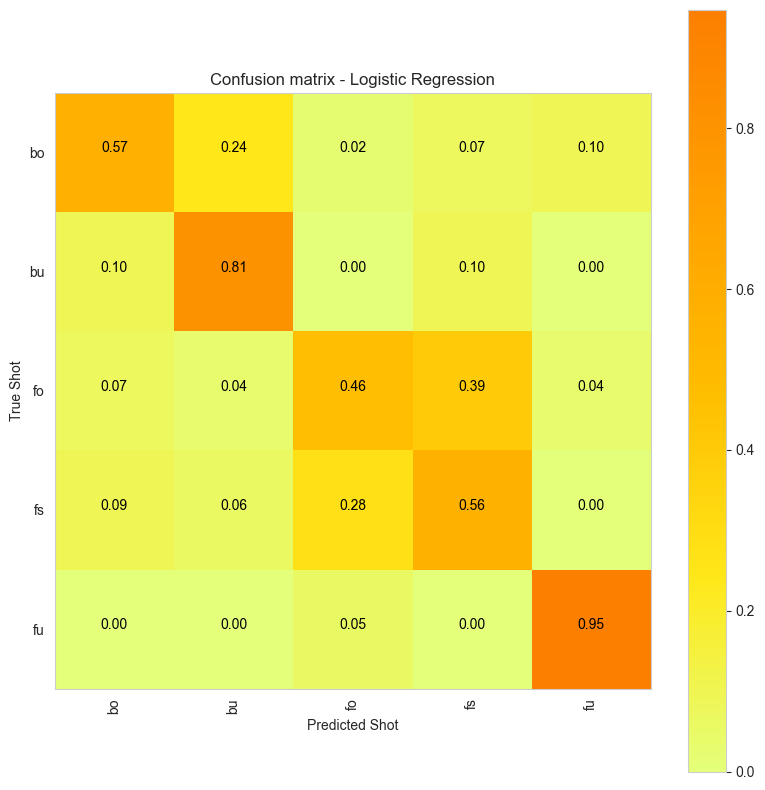

Отчет о метриках LogisticRegression
              precision    recall  f1-score   support

          bo       0.77      0.57      0.66        42
          bu       0.57      0.81      0.67        21
          fo       0.54      0.46      0.50        28
          fs       0.53      0.56      0.55        32
          fu       0.78      0.95      0.86        19

    accuracy                           0.63       142
   macro avg       0.64      0.67      0.65       142
weighted avg       0.64      0.63      0.63       142



In [33]:
from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

# Значения гиперпараметра C и типа регуляризации:
parameters = {'C':[0.01,0.1,1,10,20,30], 'penalty':['l2','l1']}
log_reg_clf = linear_model.LogisticRegression()
log_reg_model = GridSearchCV(log_reg_clf, param_grid=parameters, cv=3,verbose=1, n_jobs=8)

log_reg_model.fit(X_train,Y_train)
y_pred = log_reg_model.predict(X_test)
# y_prob = log_reg_model.predict_proba(X_test)
# print(y_prob)
accuracy = metrics.accuracy_score(y_true=Y_test,y_pred=y_pred)

# метрика Accuracy 
print('Accuracy на целевом факторе:   {}\n\n'.format(accuracy))
     
# матрица ошибок
cm = metrics.confusion_matrix(Y_test, y_pred)

plt.figure(figsize=(8,8))
plt.grid(b=False)
plot_confusion_matrix(cm, model_name="Logistic Regression", 
                      shots=shot_labels, normalize=True)
plt.show()
    
print("Отчет о метриках LogisticRegression")
classification_report = metrics.classification_report(Y_test, y_pred)
print(classification_report)

### Метод k ближайших соседей K- Nearest Neighbours

Accuracy на целевом факторе:   0.6197183098591549




C:\Users\Станислав\AppData\Local\Temp\ipykernel_5284\3141137170.py:16: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=False)


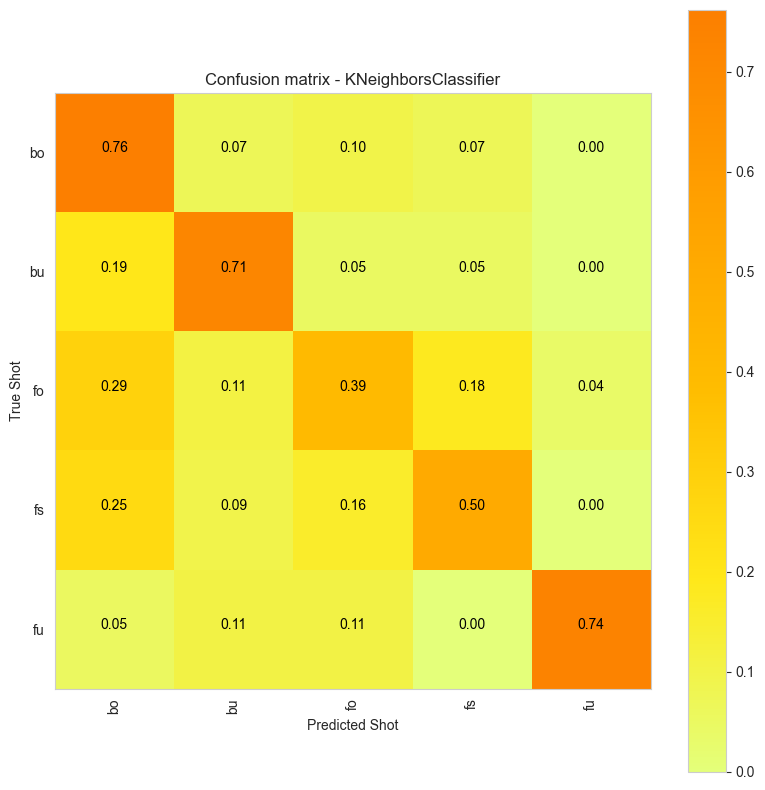

Отчет о метриках KNeighborsClassifier
              precision    recall  f1-score   support

          bo       0.60      0.76      0.67        42
          bu       0.58      0.71      0.64        21
          fo       0.48      0.39      0.43        28
          fs       0.64      0.50      0.56        32
          fu       0.93      0.74      0.82        19

    accuracy                           0.62       142
   macro avg       0.65      0.62      0.63       142
weighted avg       0.63      0.62      0.62       142



In [34]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=4)
knn.fit(X_train, Y_train)
y_pred = knn.predict(X_test)

accuracy = metrics.accuracy_score(y_true=Y_test,y_pred=y_pred)

# метрика Accuracy 
print('Accuracy на целевом факторе:   {}\n\n'.format(accuracy))
     
# матрица ошибок
cm = metrics.confusion_matrix(Y_test, y_pred)
    
plt.figure(figsize=(8,8))
plt.grid(b=False)
plot_confusion_matrix(cm, model_name='KNeighborsClassifier',
                      shots=shot_labels, normalize=True, )
plt.show()
    
print("Отчет о метриках KNeighborsClassifier")
classification_report = metrics.classification_report(Y_test, y_pred)
print(classification_report)

### Метод опорных векторов Linear Support Vector Classification (Linear SVC)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


c:\Users\Станислав\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Станислав\AppData\Local\Temp\ipykernel_5284\3383827499.py:16: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=False)


Accuracy на целевом факторе:   0.5211267605633803




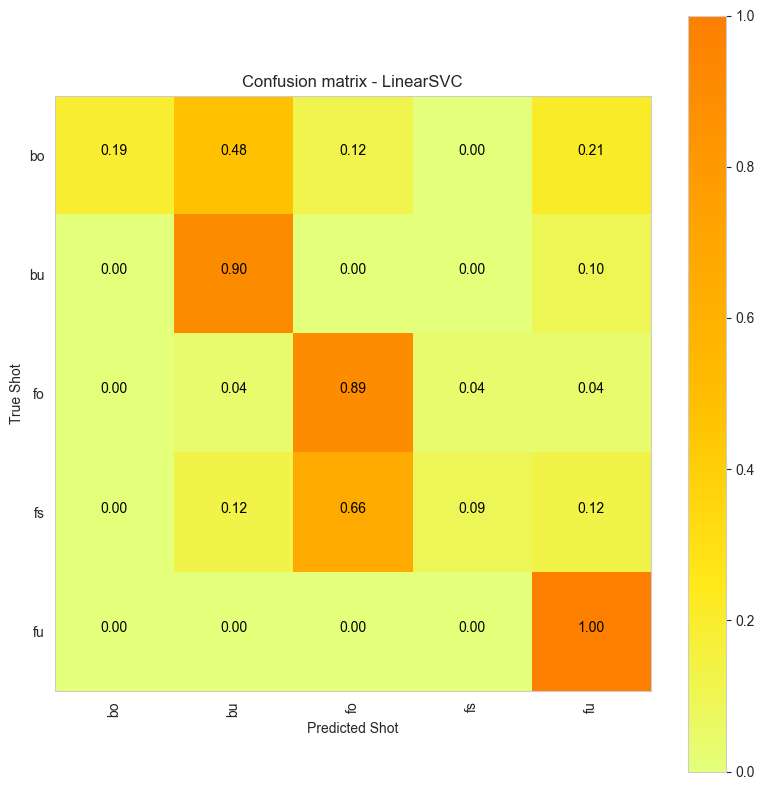

Отчет о метриках LinearSVC
              precision    recall  f1-score   support

          bo       1.00      0.19      0.32        42
          bu       0.43      0.90      0.58        21
          fo       0.49      0.89      0.63        28
          fs       0.75      0.09      0.17        32
          fu       0.54      1.00      0.70        19

    accuracy                           0.52       142
   macro avg       0.64      0.62      0.48       142
weighted avg       0.70      0.52      0.44       142



In [35]:
from sklearn.svm import LinearSVC
parameters = {'C':[0.125, 0.5, 1, 2, 8, 16]}
lr_svc_reg_clf = LinearSVC(tol=0.00005)
lr_svc_reg_model = GridSearchCV(lr_svc_reg_clf, param_grid=parameters, n_jobs=8, verbose=1)

lr_svc_reg_model.fit(X_train,Y_train)
y_pred = lr_svc_reg_model.predict(X_test)
accuracy = metrics.accuracy_score(y_true=Y_test,y_pred=y_pred)
# метрика Accuracy 
print('Accuracy на целевом факторе:   {}\n\n'.format(accuracy))
     
# матрица ошибок
cm = metrics.confusion_matrix(Y_test, y_pred)
        
plt.figure(figsize=(8,8))
plt.grid(b=False)
plot_confusion_matrix(cm, model_name='LinearSVC',
                      shots=shot_labels, normalize=True)
plt.show()
    
print("Отчет о метриках LinearSVC")
classification_report = metrics.classification_report(Y_test, y_pred)
print(classification_report)

### Метод опорных векторов SVC with RBF kernel (с ядром radial basic function)

Accuracy на целевом факторе:   0.30985915492957744




C:\Users\Станислав\AppData\Local\Temp\ipykernel_5284\3370879840.py:17: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=False)


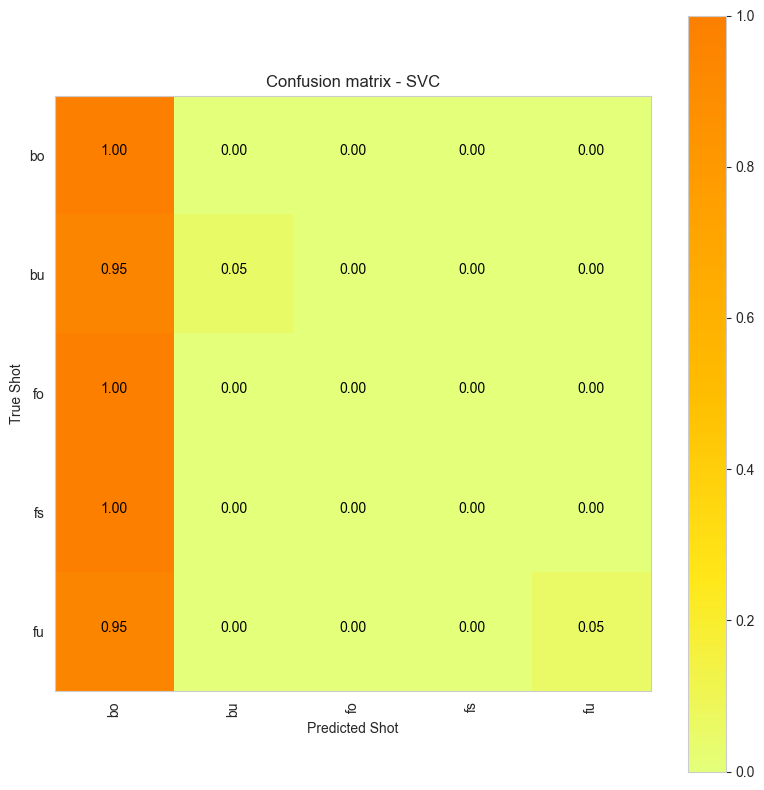

Отчет о метриках SVC with RBF kernel
              precision    recall  f1-score   support

          bo       0.30      1.00      0.46        42
          bu       1.00      0.05      0.09        21
          fo       0.00      0.00      0.00        28
          fs       0.00      0.00      0.00        32
          fu       1.00      0.05      0.10        19

    accuracy                           0.31       142
   macro avg       0.46      0.22      0.13       142
weighted avg       0.37      0.31      0.16       142



c:\Users\Станислав\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Станислав\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Станислав\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

In [36]:
from sklearn.svm import SVC
parameters = {'C':[2,8,16],\
              'gamma': [ 0.0078125, 0.125, 2]}
rbf_svm_clf = SVC(kernel='rbf')
rbf_svm_model = GridSearchCV(rbf_svm_clf,param_grid=parameters,n_jobs=8)

rbf_svm_model.fit(X_train,Y_train )
y_pred = rbf_svm_model.predict(X_test)
accuracy = metrics.accuracy_score(y_true=Y_test,y_pred=y_pred)
# метрика Accuracy
print('Accuracy на целевом факторе:   {}\n\n'.format(accuracy))
     
# матрица ошибок
cm = metrics.confusion_matrix(Y_test, y_pred)

plt.figure(figsize=(8,8))
plt.grid(b=False)
plot_confusion_matrix(cm, model_name='SVC', shots=shot_labels, normalize=True)
plt.show()
    
print("Отчет о метриках SVC with RBF kernel")
classification_report = metrics.classification_report(Y_test, y_pred)
print(classification_report)

### Деревья решений DecisionTreeClassifier 

Accuracy на целевом факторе:   0.6408450704225352




C:\Users\Станислав\AppData\Local\Temp\ipykernel_5284\851063544.py:16: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=False)


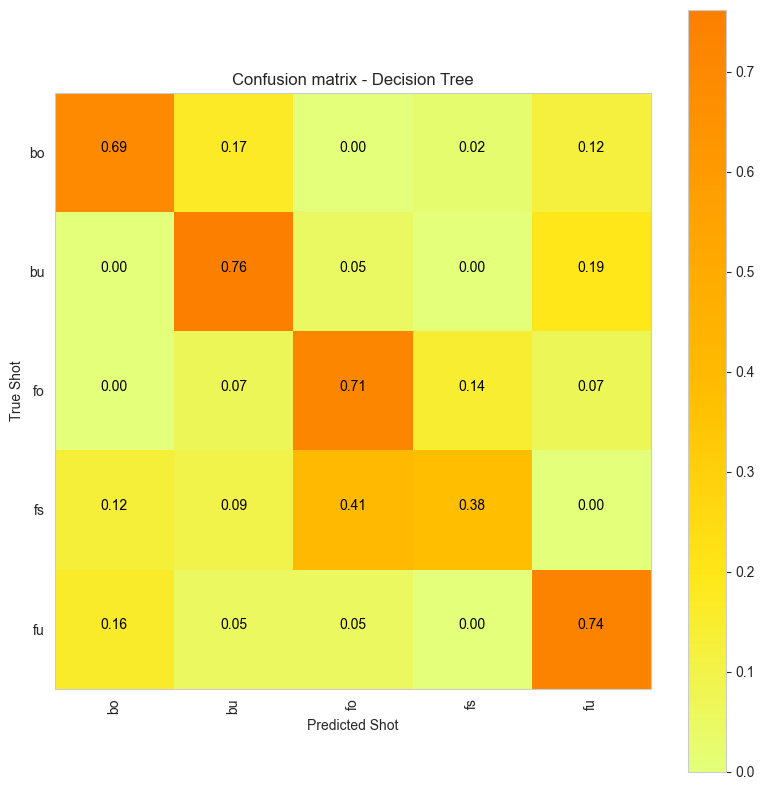

Отчет о метриках DecisionTreeClassifier
              precision    recall  f1-score   support

          bo       0.81      0.69      0.74        42
          bu       0.55      0.76      0.64        21
          fo       0.57      0.71      0.63        28
          fs       0.71      0.38      0.49        32
          fu       0.56      0.74      0.64        19

    accuracy                           0.64       142
   macro avg       0.64      0.66      0.63       142
weighted avg       0.67      0.64      0.64       142



In [37]:
from sklearn.tree import DecisionTreeClassifier
parameters = {'max_depth':np.arange(3,20,2)}
decision_trees_clf = DecisionTreeClassifier()
decision_trees = GridSearchCV(decision_trees_clf, param_grid=parameters, n_jobs=8)

decision_trees.fit(X_train,Y_train )
y_pred = decision_trees.predict(X_test)
accuracy = metrics.accuracy_score(y_true=Y_test,y_pred=y_pred)
# метрика Accuracy
print('Accuracy на целевом факторе:   {}\n\n'.format(accuracy))
     
# матрица ошибок
cm = metrics.confusion_matrix(Y_test, y_pred)

plt.figure(figsize=(8,8))
plt.grid(b=False)
plot_confusion_matrix(cm, model_name='Decision Tree',
                      shots=shot_labels, normalize=True)
plt.show()
    
print("Отчет о метриках DecisionTreeClassifier")
classification_report = metrics.classification_report(Y_test, y_pred)
print(classification_report)

### Случайный лес Random Forest

Accuracy на целевом факторе:   0.7887323943661971




C:\Users\Станислав\AppData\Local\Temp\ipykernel_5284\825829430.py:17: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=False)


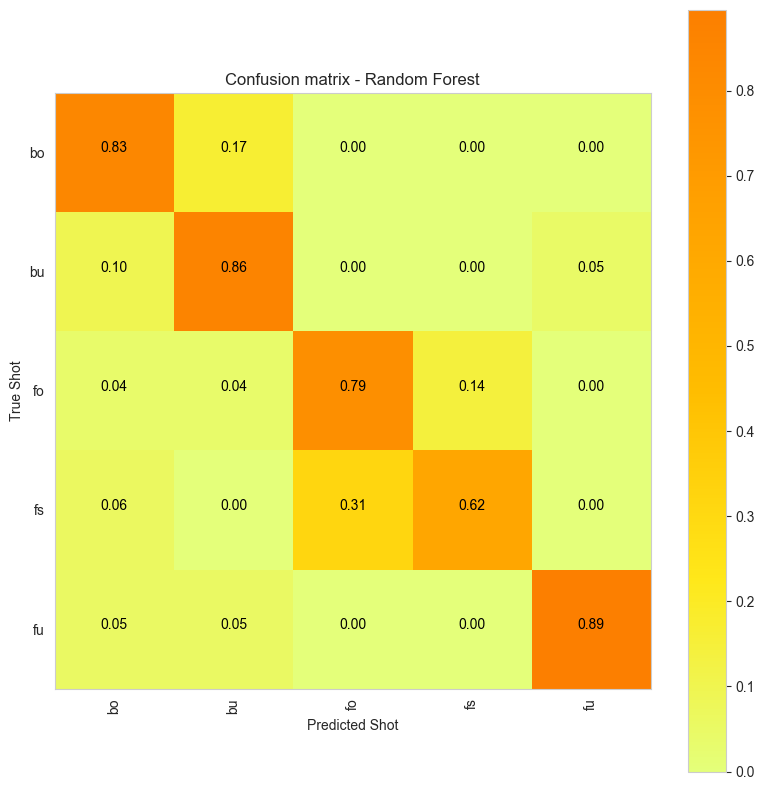

Отчет о метриках RandomForestClassifier
              precision    recall  f1-score   support

          bo       0.85      0.83      0.84        42
          bu       0.67      0.86      0.75        21
          fo       0.69      0.79      0.73        28
          fs       0.83      0.62      0.71        32
          fu       0.94      0.89      0.92        19

    accuracy                           0.79       142
   macro avg       0.80      0.80      0.79       142
weighted avg       0.80      0.79      0.79       142



In [38]:
from sklearn.ensemble import RandomForestClassifier
params = {'n_estimators': np.arange(10,120,20), 'max_depth':np.arange(3,15,2)}
rfclassifier_clf = RandomForestClassifier()
rfclassifier = GridSearchCV(rfclassifier_clf, param_grid=params, n_jobs=8)


rfclassifier.fit(X_train,Y_train )
y_pred = rfclassifier.predict(X_test)
accuracy = metrics.accuracy_score(y_true=Y_test,y_pred=y_pred)
# метрика Accuracy 
print('Accuracy на целевом факторе:   {}\n\n'.format(accuracy))
     
# матрица ошибок
cm = metrics.confusion_matrix(Y_test, y_pred)

plt.figure(figsize=(8,8))
plt.grid(b=False)
plot_confusion_matrix(cm, model_name='Random Forest',
                      shots=shot_labels, normalize=True)
plt.show()

print("Отчет о метриках RandomForestClassifier")
classification_report = metrics.classification_report(Y_test, y_pred)
print(classification_report)

### Градиентный бустинг Gradient Boosting

Accuracy на целевом факторе:   0.7323943661971831




C:\Users\Станислав\AppData\Local\Temp\ipykernel_5284\961700407.py:17: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=False)


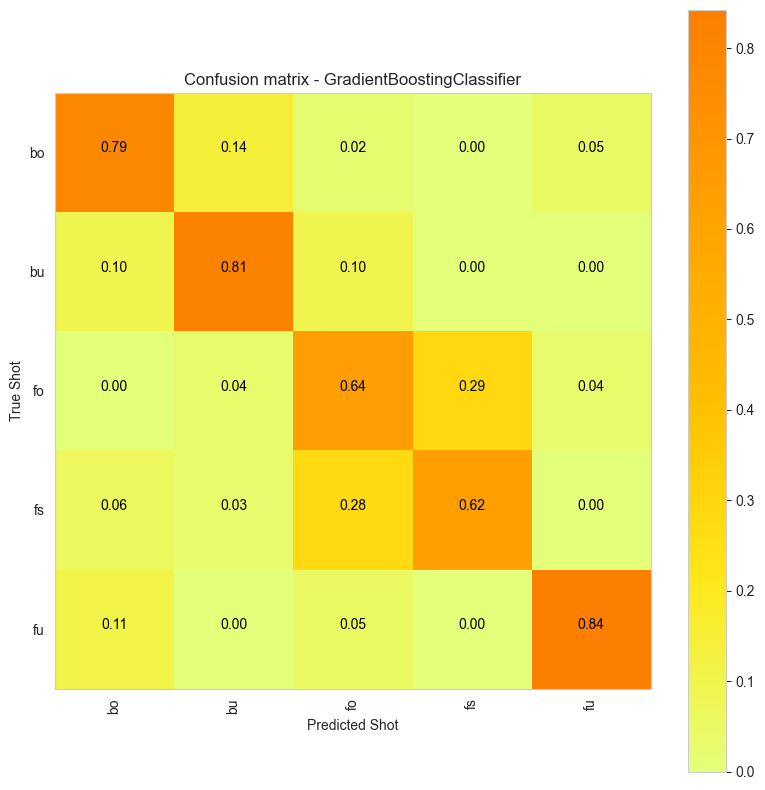

Отчет о метриках GradientBoostingClassifier
              precision    recall  f1-score   support

          bo       0.85      0.79      0.81        42
          bu       0.68      0.81      0.74        21
          fo       0.58      0.64      0.61        28
          fs       0.71      0.62      0.67        32
          fu       0.84      0.84      0.84        19

    accuracy                           0.73       142
   macro avg       0.73      0.74      0.73       142
weighted avg       0.74      0.73      0.73       142



In [39]:
from sklearn.ensemble import GradientBoostingClassifier
param_grid = {'max_depth': np.arange(1,20,10), \
             'n_estimators':np.arange(1,100,50)}
gbdt_clf = GradientBoostingClassifier()
gbdt_model = GridSearchCV(gbdt_clf, param_grid=param_grid, n_jobs=8)

gbdt_model.fit(X_train,Y_train )
y_pred = gbdt_model.predict(X_test)
accuracy = metrics.accuracy_score(y_true=Y_test,y_pred=y_pred)
# метрика Accuracy
print('Accuracy на целевом факторе:   {}\n\n'.format(accuracy))
     
# матрица ошибок
cm = metrics.confusion_matrix(Y_test, y_pred)

plt.figure(figsize=(8,8))
plt.grid(b=False)
plot_confusion_matrix(cm, model_name='GradientBoostingClassifier',
                      shots=shot_labels, normalize=True)
plt.show()
    
print("Отчет о метриках GradientBoostingClassifier")
classification_report = metrics.classification_report(Y_test, y_pred)
print(classification_report)

## Выводы

Этот дипломный проект многому научил меня в реализации проекта машинного обучения. Особенно много задач возникает при сборе данных и их предварительной обработке. Данный проект можно расширить несколькими способами, прежде всего за счет получения большего количества данных, чтобы можно было использовать более сложные модели, относящиеся к Deep Learning Models, такие как LSTM. Для классических моделей мы можем добавить больше признаков, воспользоваться методом главных компонент (PCA). В целом я получил отличный опыт обучения в решении задачи классификации а так же данное исследование актуально как расширение задачи распознавания человеческой активности, которая на основе аналогичных данных классифицирует действия человека, такие как бег, ходьба и т. д. Посмотрим на метрики которые мы получили и сравним результаты:

|Модель/Метрика   | **Accuracy** | **F1-score bo** | **F1-score bu** | **F1-score fo** | **F1-score fs** |**F1-score fu** |
|----------------|---------------|--------------|-------------------|-----------------|------------------|-----------------|
|**Logistic Regression**       | 0.634 | 0.66 | 0.67 | 0.50 | 0.55 | 0.86 |   
|**K-Nearest Neighbours**       | 0.620 | 0.67 | 0.64 | 0.43 | 0.56 | 0.82 |   
|**Linear SVC**                 | 0.662 | 0.81 | 0.47 | 0.43 | 0.65 | 0.75 |    
|**SVC with RBF kernel**       | 0.310 | 0.46 | 0.09 | 0.00 | 0.00 | 0.10 |    
|**Decision Tree**               | 0.655 | 0.71 | 0.69 | 0.66 | 0.50 | 0.72 |    
|**Random Forest**                     | 0.796 | 0.86 | 0.76 | 0.71 | 0.72 | 0.94 |    
|**Gradient Boosting**                 | 0.732 | 0.81 | 0.74 | 0.61 | 0.67 | 0.84 |     

Модели разделились по следующему принципу: Модели на основе Деревьев решений показали более высокие результаты предсказания целевого признака, что нельзя сказать о моделях основанных на методе опорных векторов SVC. SVC с ядром RBF не отражает классификацию разбиения нашей выборки поэтому не может быть использована в дальнейшем. Метод ближайших соседей и логистическая регрессия показали хорошие результаты прогнозирования но уступают Деревьям решений оптимизация гиперпараметров которых была произведена качественно.Предложенное решение может быть реализовано в продакшене при проведении его сериализации и деплоя. 